In [146]:
import torch
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

data = pd.read_csv('gmm_1d.csv')

data_t = torch.tensor(data['y_i'])

In [157]:
# def likelihood(data_t, mus, vars, mws):
lr = 1e-3

# mus = torch.distributions.Uniform(1.0, 2.0).sample(torch.tensor([4]))
# mus.requires_grad = True
mus = torch.tensor([-0.9, 1.0, 4.0, 2.0], requires_grad=True, dtype=torch.float)
num_components = mus.shape[0]

log_mixing_weights = torch.tensor(np.log(num_components * [1 / num_components]), dtype=torch.double, requires_grad=True)
log_sigmas = torch.zeros_like(mus).requires_grad_(True)

n_epochs = 100
history = {
    "loglikelihood": [],
    "mus": [],
    "log_sigmas": [],
    "log_mixing_weights": [],
}

In [158]:
def loglikelihood(mus, vars, log_mixing_weights):
    num_components = mus.shape[0]
    densities = []
    for component in range(num_components):
        component_dist = torch.distributions.Normal(loc=mus[component], scale=log_sigmas[component].exp())
        density = component_dist.log_prob(data_t).exp()
        densities.append(density)
    densities = torch.stack(densities, dim=1)
    mixing_weights = torch.softmax(log_mixing_weights, dim=0)

    return torch.sum(mixing_weights * densities, dim=1).log().sum()


for epoch in range(n_epochs):
    
    ll = loglikelihood(mus, log_sigmas, log_mixing_weights)
    ll.backward()

    ll_item = ll.detach().item()

    with torch.no_grad():
        # gradient step
        mus += mus.grad * lr
        log_sigmas += log_sigmas.grad * lr
        log_mixing_weights += log_mixing_weights.grad * lr

        # zero-out gradients
        _ = [ x.grad.zero_() for x in (mus, log_sigmas, log_mixing_weights)]
        
        history["loglikelihood"].append(ll_item)
        history["mus"].append(mus.clone().numpy())
        history["log_sigmas"].append(log_sigmas.clone().numpy())
        history["log_mixing_weights"].append(log_mixing_weights.clone().numpy())

for k in ("mus", "log_sigmas", "log_mixing_weights"):
    history[k] = np.stack(history[k])


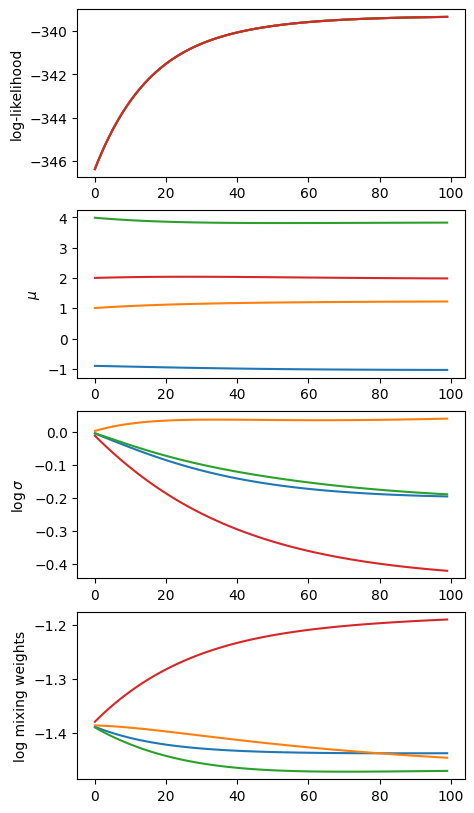

In [159]:
fig, ax = plt.subplots(nrows=4, figsize=(5,10))

n_components = history["mus"].shape[1]

for cmpt in range(n_components):
    ax[0].plot(history["loglikelihood"])
    ax[0].set(ylabel="log-likelihood")
    ax[1].plot(history["mus"][:, cmpt])
    ax[2].plot(history["log_sigmas"][:, cmpt])
    ax[3].plot(history["log_mixing_weights"][:, cmpt])
    ax[1].set(ylabel=r"$\mu$")
    ax[2].set(ylabel=r"$\log \sigma$")
    ax[3].set(ylabel=r"log mixing weights")

plt.show()

In [160]:
log_sigmas.clone().detach().exp()
# log_mixing_weights.clone().detach().exp()

tensor([0.8226, 1.0416, 0.8279, 0.6564])

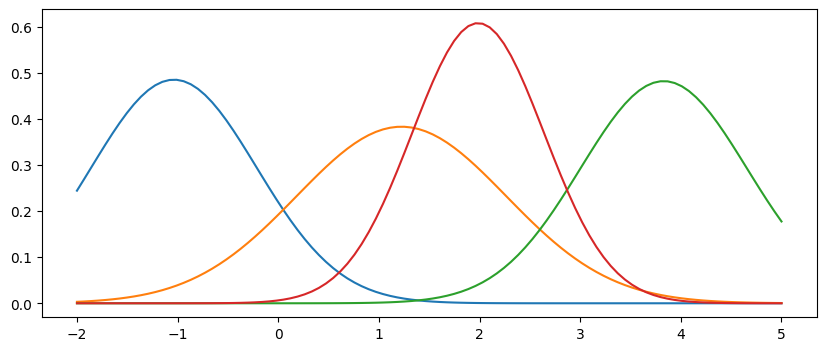

In [162]:
mu_opt = mus.clone().detach()
sigma_opt = log_sigmas.clone().detach().exp()

fig, ax = plt.subplots(figsize=(10,4))

x = np.linspace(-2.0, 5.0, 100)
for i in range(len(mu_opt)):
    ax.plot(x, ss.norm.pdf(x, mu_opt[i], sigma_opt[i]))
plt.show()

In [163]:
log_mixing_weights.exp()

tensor([0.2374, 0.2354, 0.2298, 0.3041], dtype=torch.float64,
       grad_fn=<ExpBackward0>)

In [164]:
n = torch.tensor([40, 50, 30, 50])
n / n.sum()

tensor([0.2353, 0.2941, 0.1765, 0.2941])